**First Try at a Data Analysis Using FastF1**

1. Importing Necessary Libraries and Modules

In [2]:
# Importing all Required Libraries

import fastf1 as ff1
from fastf1 import plotting
from fastf1 import utils
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

2. Creating a Cache for the requeired Information

In [3]:
# Importing the Information into the "cache" folder: 
ff1.Cache.enable_cache('cache') 

3. Getting the Bahrain Event Details (Qualy at First)

In [9]:
# Loading the "Session" Object
quali = ff1.get_session(2022,'Bahrain','Q')
quali.load()


core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v2.2.2]
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached data found for session_status_data. Loading data...
api            INFO 	Fetching session status data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for track_status_data. Loading data...
api            INFO 	Fetching tra

4. Getting a List of Driver's Tags and Team Names

In [42]:
Drivers = pd.unique(quali.laps['Driver'])
Teams = pd.unique(quali.laps['Team'])

print(Drivers)
print('\n')
print(Teams)

['LEC' 'VER' 'SAI' 'PER' 'HAM' 'BOT' 'MAG' 'ALO' 'RUS' 'GAS' 'OCO' 'MSC'
 'NOR' 'ALB' 'ZHO' 'TSU' 'HUL' 'RIC' 'STR' 'LAT']


['Ferrari' 'Red Bull Racing' 'Mercedes' 'Alfa Romeo' 'Haas F1 Team'
 'Alpine' 'AlphaTauri' 'McLaren' 'Williams' 'Aston Martin']


5. Selecting the Fastest Lap from each Team

In [55]:
# Empty Dictionary
team_fastest_lap = {}

# Filling the Fastest Lap Dictionary 
for team in Teams: 
    team_fastest_lap[team] = quali.laps[quali.laps.Team == team].pick_fastest()

# Displaying Red Bull's Lap as an Example
team_fastest_lap['Red Bull Racing'].head()


Time            0 days 01:15:15.614000
DriverNumber                         1
LapTime         0 days 00:01:30.681000
LapNumber                           14
Stint                                4
dtype: object

6. Selecting the "Pole" Lap (Fastest Time Overall)

In [56]:
fastest_lap = quali.laps.pick_fastest()
print(fastest_lap.head())

Time            0 days 01:14:47.968000
DriverNumber                        16
LapTime         0 days 00:01:30.558000
LapNumber                           14
Stint                                5
dtype: object


7. Remaking the Team's colors (just Switching Hass from White to black)

In [73]:

Team_Colors_Dict = {}

for team in Teams:

    if team != 'Haas F1 Team':
        Team_Colors_Dict[team] = plotting.team_color(team)
    else: 
        Team_Colors_Dict[team] = '#000000'

Team_Colors_Dict




{'Ferrari': '#dc0000',
 'Red Bull Racing': '#0600ef',
 'Mercedes': '#00d2be',
 'Alfa Romeo': '#900000',
 'Haas F1 Team': '#000000',
 'Alpine': '#0090ff',
 'AlphaTauri': '#2b4562',
 'McLaren': '#ff8700',
 'Williams': '#005aff',
 'Aston Martin': '#006f62'}

7. Comparing theb Team's fastest laps and The fastest lap overall:

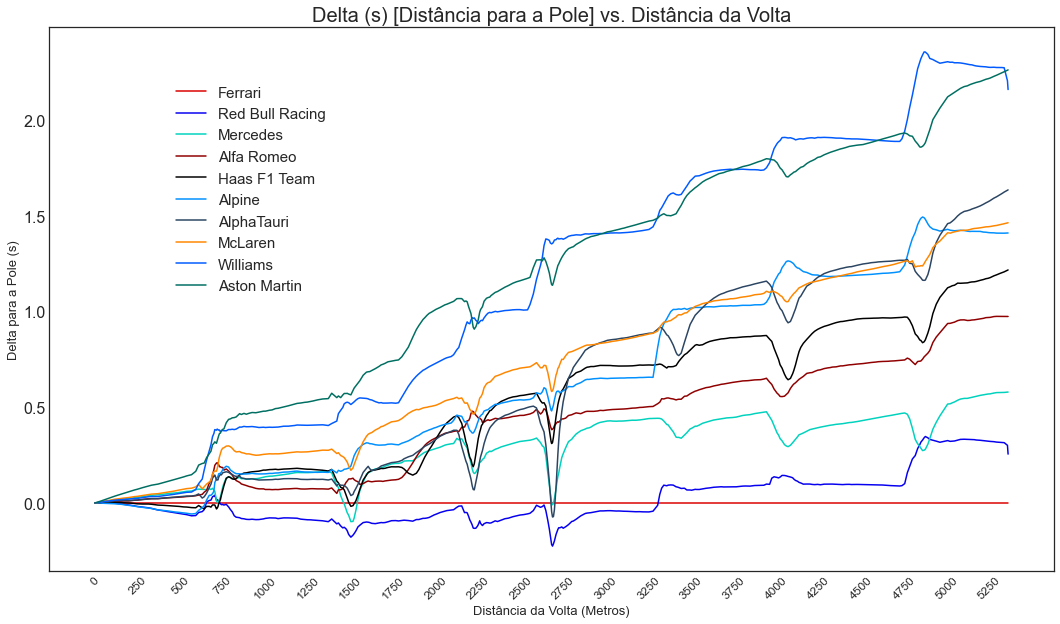

In [94]:
from matplotlib import rcParams
plt.style.use('seaborn-white')

rcParams['figure.figsize'] = (18,10)

ax = plt.axes()


for team in team_fastest_lap:
    delta_time, ref_tel, compare_tel = utils.delta_time(fastest_lap, team_fastest_lap[team])
    plt.plot(ref_tel['Distance'], delta_time, color = Team_Colors_Dict[team], label = team)

plt.ylabel("Delta para a Pole (s)", fontdict={'size': 13})
plt.xlabel("Distância da Volta (Metros)", fontdict={'size': 13})
plt.title('Delta (s) [Distância para a Pole] vs. Distância da Volta', fontdict={'size': 20})
plt.xticks(np.arange(0, np.max(ref_tel['Distance']), step=250), rotation = 45, fontsize = 12)
plt.yticks(fontsize = 16)
plt.legend(loc = (.12,.5), prop = {'size':15})
plt.show()

8. Plotting The Circuit By Pole Lap

<AxesSubplot:xlabel='x', ylabel='y'>

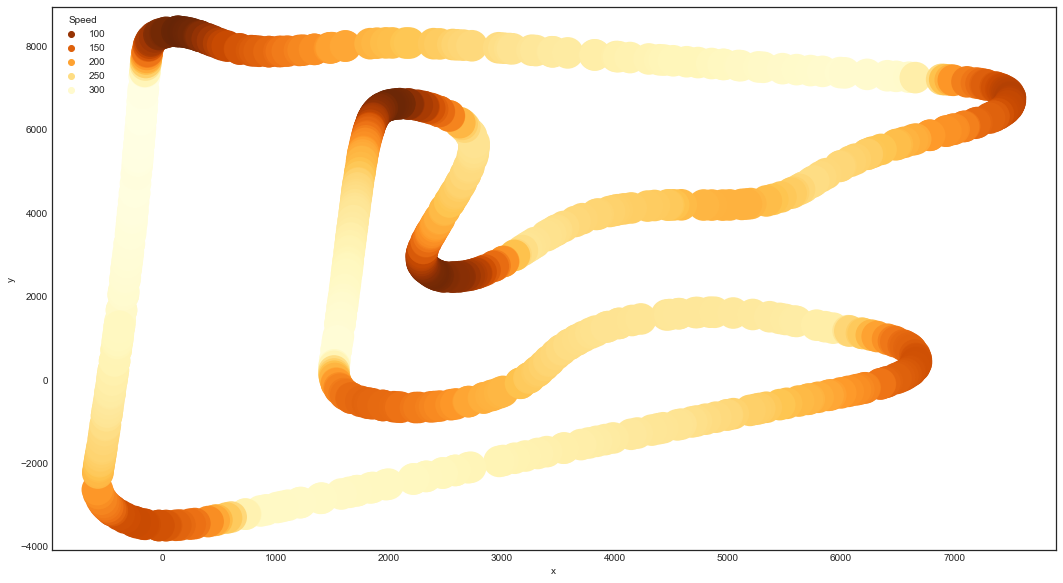

In [190]:
import seaborn as sns
sns.color_palette("rocket")

Telemetria_Pole = fastest_lap.get_telemetry()
x = np.array(Telemetria_Pole['X'].values)
y = np.array(Telemetria_Pole['Y'].values)
speed = Telemetria_Pole['Speed'].to_numpy().astype(int)

Dados_Plot = pd.DataFrame(data={'x':x,'y':y,'Speed':speed})

sns.scatterplot(data = Dados_Plot, x = 'x', y = 'y', hue = 'Speed', s = 1000, linewidth = 0, palette = 'YlOrBr_r')


<AxesSubplot:xlabel='x', ylabel='y'>

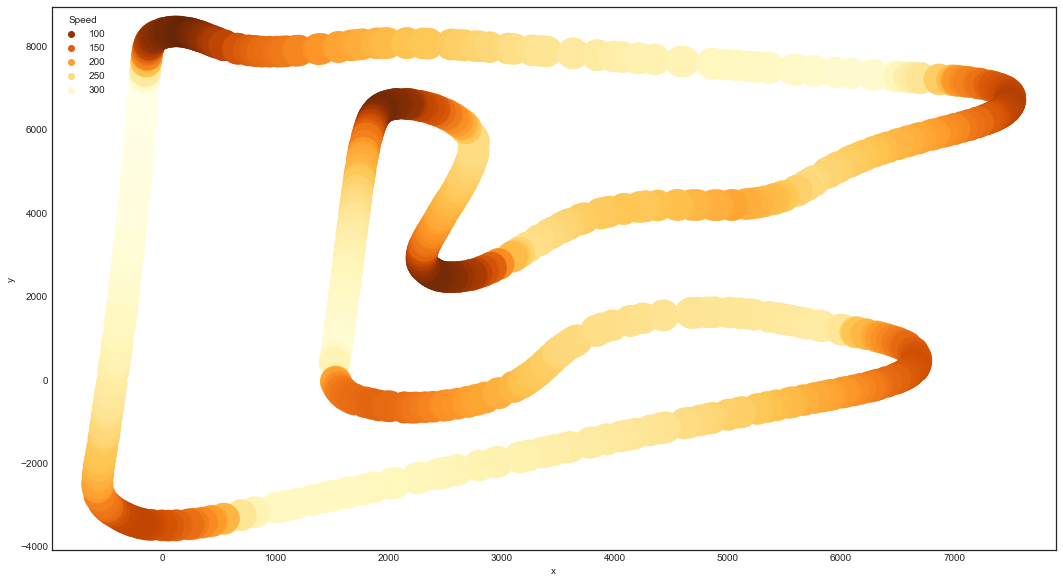

In [191]:
import seaborn as sns
sns.color_palette("rocket")

Telemetria_Ver = team_fastest_lap['Red Bull Racing'].get_telemetry()
x = np.array(Telemetria_Ver['X'].values)
y = np.array(Telemetria_Ver['Y'].values)
speed = Telemetria_Ver['Speed'].to_numpy().astype(int)

Dados_Ver = pd.DataFrame(data={'x':x,'y':y,'Speed':speed})

sns.scatterplot(data = Dados_Ver, x = 'x', y = 'y', hue = 'Speed', s = 1000, linewidth = 0, palette = 'YlOrBr_r')

In [187]:
Telemetria_Pole['RelativeDistance']


2      0.000006
3      0.001283
4      0.002319
5      0.005868
6      0.005991
         ...   
694    0.991791
695    0.993405
696    0.994483
697    0.997002
698    0.997692
Name: RelativeDistance, Length: 697, dtype: float64